In [53]:
# Librerias:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

import matplotlib.pyplot as plt

In [54]:
# Método para el cálculo del índice Gini normalizado:
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    gini = lambda a, p: 2 * metrics.roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

### Datos de entrenamiento (train data):

Cargando datos de entrenamiento:

In [55]:
train_df = pd.read_csv('./Datos/train.csv')
train_df.rename(columns={'Unnamed: 0':'first_col'}, inplace=True)
# train_df

Etiquetas del conjunto de entrenamiento (training labels):

In [56]:
train_labels_df = pd.read_csv('./Datos/train_label.csv', header=None)
train_labels_df.rename(columns={0:'train_labels'}, inplace=True)
# train_labels_df

**Relación entre las clases:** \
A continuación se calcula la relación entre las clases involucradas en este trabajo. De esta forma verificamos que tan desbalanceado se encuentran los grupos y así obtenemos indicios de cómo enfrentar el proceso de clasificación requerido.

In [57]:
pos_class = train_labels_df[train_labels_df['train_labels'] == 1].shape[0]
neg_class = train_labels_df.shape[0] - pos_class

print(f'Total amount of classes = {train_labels_df.shape[0]}')
print(f'Positive class elements = {pos_class}')
print(f'Negative class elements = {neg_class}')
print(f'Class ratio: (0:1) --> ({np.round(neg_class/pos_class)}:{pos_class/pos_class})')

Total amount of classes = 2189
Positive class elements = 429
Negative class elements = 1760
Class ratio: (0:1) --> (4.0:1.0)


En este caso vemos que el conjunto de datos tiene una relación 4:1, es decir que por cada clase positiva hay cuatro clases negativas. De esta manera se comprueba el grado de desbalance de los datos.

### Datos de validación (test data):

In [58]:
test_df = pd.read_csv('./Datos/test.csv')
test_df.rename(columns={'Unnamed: 0':'first_col'}, inplace=True)
# test_df

Cargando etiquetas de validación (Loading test labels):

In [59]:
test_labels_df = pd.read_csv('./Datos/test_label.csv', header=None)
test_labels_df.rename(columns={0:'test_labels'}, inplace=True)
# test_labels_df

## Entrenamiento y validación de modelos:

Debido a la naturaleza de los datos ofrecidos para este problema de clasificación, se ha decido realizar varios experimentos para probar diferentes hipótesis de trabajo. En la mayoría de los escenarios propuestos se trabajará con datos balanceados, así que como primera medida realizaremos el balanceo de datos a través del submuestreo de la clase minoritaria.
A continuación se presenta cada experimento con su respectiva descripción y los resultados obtenidos.

In [60]:
# Datos en formato numpy: 
train_data = train_df.values
train_labels = train_labels_df.values

**Balanceo de datos para el conjunto de entrenamiento:**

Para este procedimiento utilizamos el método de sobre-muestreo de la clase minoritaria (en inglés, Synthetic Minority Over-sampling Technique - SMOTE) con el fin de obtenier igual número de muestras para ambas clases de trabajo.
Cómo se podrá observar, utilizamos el método SMOTE proveniente de la librería **imbalanced learn**. Es importante destacar que este método nos dió los mismos resultados que la función de sobre-muestreo que implementé; sin embargo, utilizo la librería en mención ya que tiene acople directo con scikit learn, pandas y todo el eco-sistema de python para análisis de datos.

In [61]:
# Instanciamos el método SMOTE para realizar el sobre-muestreo:
sm = SMOTE(random_state=0)

In [62]:
# Sobre-muestreo del conjunto de entrenamiento:
train_data_res, train_labels_res = sm.fit_resample(train_data, train_labels)

In [63]:
# Corroborando el tamaño de los nuevos datos de entrenamiento:
train_data_res.shape

(3520, 72)

En la celda anterior puede verse cómo el nuevo conjunto de entrenamiento es igual a dos veces el tamaño del conjunto originalmente compuesto por la clase mayoritaria (class = 0).

In [64]:
# Verficando la distribución de las nuevas etiquetas: 
print(f'Training set label 0: {sum(train_labels_res == 0)}')
print(f'Training set label 1: {sum(train_labels_res == 1)}')

Training set label 0: 1760
Training set label 1: 1760


El resultado anterior muestra una balanceada distribución de las etiquetas de entrenamiento y por tanto podemos concluir que el proceso de sobre-muestreo ha sido exitoso.

### Experimento 1:
En este primer experimento se decidió utilizar un algoritmo básico de árboles de decisión entrenado con los datos balanceados. Para hacer más robusto el procedimiento de entrenamiento, se decidió utilizar validación cruzada por pliegues (K-Fold Cross Validation) para dar mayor aleatoridad en esta parte del proceso de aprendizaje.
Finalmente se analiza el desempeño del algoritmo mediante la clasificación del conjunto de validación (test) y los índices propuestos en la prueba (f1-score y Gini).

**Entrenamiento:**

In [65]:
# Modelo de clasificación
tree_clf = DecisionTreeClassifier()

In [66]:
# Usand K-fold para aumentar aleatoriedad durante el entrenamiento:
kf = KFold(n_splits=10, shuffle=True, random_state=1)

i = 1
f1 = np.zeros(10)
gini = np.zeros(10)
for train_index, test_index in kf.split(train_data_res, train_labels_res):
    X_train = train_data_res[train_index]
    y_train = train_labels_res[train_index]
    
    X_test = train_data_res[test_index]
    y_test = train_labels_res[test_index]
    
    tree_clf.fit(X_train, y_train)
    y_pred = tree_clf.predict(X_test)
    
    # Training Metrics: f1-score and Gini
    # print(f'k-fold = {i}')
    f1[i-1] = metrics.f1_score(y_test, y_pred)
    gini[i-1] = gini_normalized(y_test, y_pred)
    # print(f'f1-score = {f1[i-1]}')
    # print(f'Gini score = {gini[i-1]}')
    # print('\n')
        
    i+=1

print(f'Average f1 score = {f1.mean()}')
print(f'Average Gini score = {gini.mean()}')

Average f1 score = 0.921111652474172
Average Gini score = 0.8420129161762272


**Peso de las variables consideradas por el algoritmo de clasificación:**

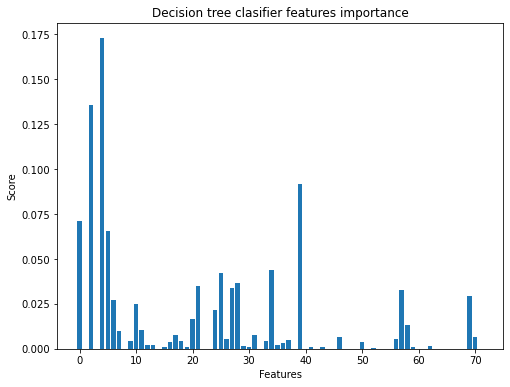

In [67]:
importance = tree_clf.feature_importances_

# Resumen de la importancia de las variables de entrenamiento:
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Decision tree clasifier features importance')
plt.ylabel("Score")
plt.xlabel("Features")
plt.show()

**Validación:**

In [68]:
# Predicciones usando el algoritmo entrenado:
tree_pred = tree_clf.predict(test_df.values)

In [69]:
pred_f1_score = metrics.f1_score(test_labels_df.values, tree_pred)
pred_gini_score = gini_normalized(test_labels_df.values, tree_pred)

print('Decision tree calssifier metrics for validation stage:')
print(f'f1-score = {pred_f1_score}')
print(f'Gini score = {pred_gini_score}')

Decision tree calssifier metrics for validation stage:
f1-score = 0.7148936170212766
Gini score = 0.680050505050505


NOTA: Se puede ver que el método se sobre entrenó y no tiene un buen desempeño al ser puesto a prueba con datos que no conoce.

### Experimento 2:
En este caso usamos un método mucho más robusto, conocido como clasificador de bosques aleatorios (Random Forest Classifier). En este caso el experimento consiste en usar los datos originales (no-balanceados), entrenar sin validación cruzada y analizar el desempeño del clasificador.
Este procedimiento servirá como base para comparar futuras pruebas que invlucran el mismo algoritmo pero datos balanceados.

**Entrenamiento:**

In [70]:
# Instancia del modelo y entrenamiento con datos no-balanceados:
rfc = RandomForestClassifier(random_state=2).fit(train_data, train_labels.ravel())

Performance con los datos de entrenamiento:

In [71]:
train_predicts = rfc.predict(train_data)
metrics.f1_score(train_labels, train_predicts), gini_normalized(train_labels, train_predicts)

(1.0, 1.0)

**Peso de las variables consideradas por el algoritmo de clasificación durante el entrenamiento:**

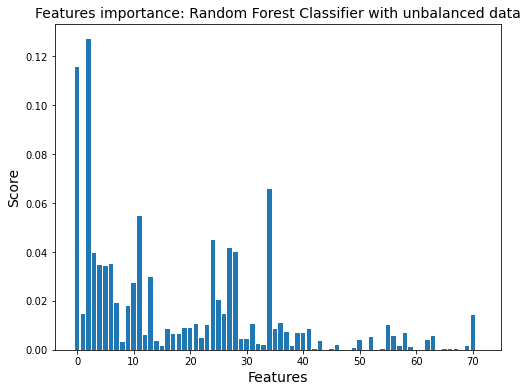

In [72]:
importance = rfc.feature_importances_

# Resumen de la importancia de las variables de entrenamiento:
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Features importance: Random Forest Classifier with unbalanced data', fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.show()

**Validación:**

In [73]:
# Predicciones usando el modelo entrenado:
rfc_predictions = rfc.predict(test_df.values)

In [74]:
pred_f1_score = metrics.f1_score(test_labels_df.values, rfc_predictions)
pred_gini_score = gini_normalized(test_labels_df.values, rfc_predictions)

print('Random Forest Classifier metrics for validation stage:')
print(f'f1-score = {pred_f1_score}')
print(f'Gini score = {pred_gini_score}')

Random Forest Classifier metrics for validation stage:
f1-score = 0.7596153846153846
Gini score = 0.6837542087542086


NOTA: Mejor desempeño que el obtenido en el experimento 1. Sin embargo, no se puede determinar que sea la mejor clasificación al problema tratado.

### Experimento 3:
Clasificador de bosques aleatorios (Random Forest Classifier) entrenado con datos balanceados obtenidos usando el método SMOTE. En este caso el experimento consiste en usar los datos balanceados, entrenar sin validación cruzada y analizar el desempeño del clasificador.

**Entrenamiento:**

In [75]:
# Instancia del modelo y entrenamiento con datos balanceados:
rfc1 = RandomForestClassifier(random_state=3).fit(train_data_res, train_labels_res)

Performance con los datos de entrenamiento:

In [76]:
train_predicts = rfc1.predict(train_data_res)
metrics.f1_score(train_labels_res, train_predicts), gini_normalized(train_labels_res, train_predicts)

(1.0, 1.0)

**Peso de las variables consideradas por el algoritmo de clasificación durante el entrenamiento:**

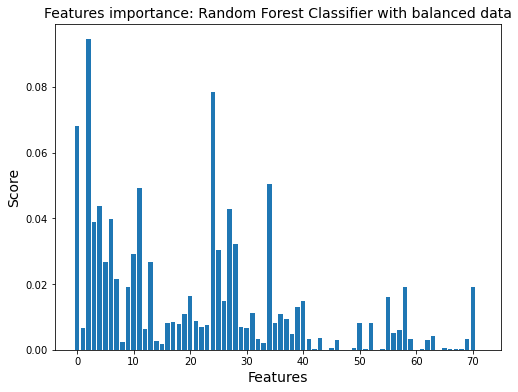

In [77]:
importance = rfc1.feature_importances_

# Resumen de la importancia de las variables de entrenamiento:
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Features importance: Random Forest Classifier with balanced data', fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.show()

**Validación:**

In [78]:
# Predicciones usando el modelo entrenado:
rfc1_predictions = rfc1.predict(test_df.values)

In [79]:
pred_f1_score = metrics.f1_score(test_labels_df.values, rfc1_predictions)
pred_gini_score = gini_normalized(test_labels_df.values, rfc1_predictions)

print('Random Forest Classifier metrics for validation stage:')
print(f'f1-score = {pred_f1_score}')
print(f'Gini score = {pred_gini_score}')

Random Forest Classifier metrics for validation stage:
f1-score = 0.7671232876712328
Gini score = 0.7164141414141412


NOTA: Mejor desempeño que el obtenido en el experimento 2, donde se usaron los datos no-balanceados. Sin embargo, parece que el balanceo del conjunto de datos no genera fuerte influencia sobre el entrenamiento del método usado.

### Experimento 4:
En este caso usamos un algoritmo mucho más robusto, basado en árboles de decisión y conocido como **Gradient Boosting Classifier**. No usamos validación cruzada y el objetivo es trabajar con los datos balanceados para mejorar las predicciones a realizar.

**Entrenamiento:**

In [80]:
# Generando el modelo y entrenando con datos desbalanceados:
gbc_clf = GradientBoostingClassifier(n_estimators=100).fit(train_data_res, train_labels_res)

Performance con los datos de entrenamiento:

In [81]:
train_predicts = rfc1.predict(train_data_res)
metrics.f1_score(train_labels_res, train_predicts), gini_normalized(train_labels_res, train_predicts)

(1.0, 1.0)

**Peso de las variables consideradas por el algoritmo de clasificación durante el entrenamiento:**

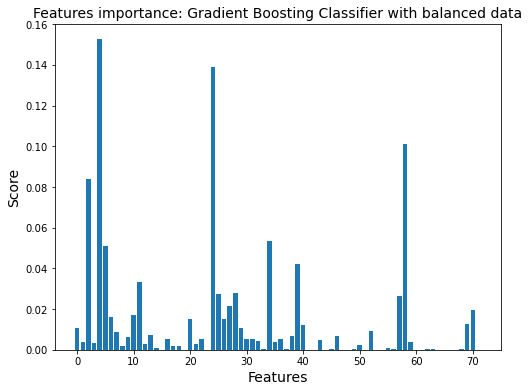

In [82]:
importance = gbc_clf.feature_importances_

# Resumen de la importancia de las variables de entrenamiento:
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Features importance: Gradient Boosting Classifier with balanced data', fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.show()

In [83]:
# print('Feature importances')
# importance[importance > 0.04]

**Validación:**

In [84]:
# Predicciones usando el modelo entrenado:
gbc_predictions = gbc_clf.predict(test_df.values)

In [85]:
pred_f1_score = metrics.f1_score(test_labels_df.values, gbc_predictions)
pred_gini_score = gini_normalized(test_labels_df.values, gbc_predictions)

print('Gradient Boosting Classifier metrics for validation stage:')
print(f'f1-score = {pred_f1_score}')
print(f'Gini score = {pred_gini_score}')

Gradient Boosting Classifier metrics for validation stage:
f1-score = 0.7705627705627707
Gini score = 0.7468013468013466


NOTA: Mejora en la clasificación de las clases, pero se sigue presentando sobre ajuste en el entrenamiento del modelo. Empiezo a pensar que las variables características (features) usadas aportan información redundante a los modelos.

### Experimento 5:
Teniendo en cuenta el desempeño de los algorítmos basados en árboles de decisión utilizados en los anteriores experimentos, se decidió utilizar en esta prueba un método de clasificación diferente. Esto se hace con el fin de observar la influencia de los datos en otros entornos de trabajo y determinar si aportan o no información redundante en el entrenamiento de los distintos métodos usados.
Pra este caso hemos decidido utilizar un clasificador de primeros vecinos (K-Nearest Neighbors Classifier), con datos de entrenamiento balanceados y validación cruzada (k-fold cv).

Cómo primera medida debemos normalizar los datos, puesto que este método se basa en distancia y la presencia de grandes variaciones en el rango de las variables características (features) pueden afectar su desempeño.

In [86]:
# Normalización de datos para entrenamiento y test:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # Instancia del objeto scaler

# Escalamiento de los datos
df_norm_train = pd.DataFrame(scaler.fit_transform(train_data_res), columns=train_df.columns)
df_norm_test = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns)

# df_norm_train

**Entrenamiento:**

In [87]:
# Genearción del modelo de clasificación:
knn = KNeighborsClassifier(n_neighbors=5)

In [88]:
# Datos a formato ndarray:
# train_data = train_df.values
train_data = df_norm_train.values
train_labels = train_labels_res

# K-fold:
knn_kf = KFold(n_splits=10, shuffle=True, random_state=10)

i = 1
f1 = np.zeros(10)
gini = np.zeros(10)
for train_index, test_index in knn_kf.split(train_data, train_labels):
    X_train = train_data[train_index]
    y_train = train_labels[train_index]
    
    X_test = train_data[test_index]
    y_test = train_labels[test_index]
    
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    
    # Training Metrics: f1-score and Gini
    # print(f'k-fold = {i}')
    f1[i-1] = metrics.f1_score(y_test, y_pred)
    gini[i-1] = gini_normalized(y_test, y_pred)
    # print(f'f1-score = {f1[i-1]}')
    # print(f'Gini score = {gini[i-1]}')
    # print('\n')
        
    i+=1

print(f'Average f1 score = {f1.mean()}')
print(f'Average Gini score = {gini.mean()}')

Average f1 score = 0.9157021506743398
Average Gini score = 0.8246330969065777


**Validación:**

In [89]:
# Making predictions:
# knn_predictions = knn.predict(test_df.values)
knn_predictions = knn.predict(df_norm_test.values)

In [90]:
pred_f1_score = metrics.f1_score(test_labels_df.values, knn_predictions)
pred_gini_score = gini_normalized(test_labels_df.values, knn_predictions)

print('K-NN metrics for validation stage:')
print(f'f1-score = {pred_f1_score}')
print(f'Gini score = {pred_gini_score}')

K-NN metrics for validation stage:
f1-score = 0.6940298507462688
Gini score = 0.7088383838383838


NOTA: En este caso obtenemos un mejor desempeño en la etapa de entrenamiento del modelo; Sin embargo, al realizar la validación no obtenemos el resultado esperado. Esto nos hace pensar que los datos no poseen información relevante para la terea sugerida.

### Experimento 6:
En este experimento validaremos la hipótesis de redundancia de información. Para esto usaremos un Random Forest Classifier entrenado y puesto a prueba con sólo una parte de los datos, específicamente aquellos tipo 'float64' (ya que tienen distribuciones más grandes de sus datos).
El orden del trabajo será:
- Extraer las características deseadas
- Balancear el grupo de entrenamiento
- Entrenar el modelo
- Validar el modelo

In [91]:
# Extracción de las características (datos/features) a utlizar en el entrenamiento:

# numeric_features = train.select_dtypes(include=['int64', 'float64']).columns
selected_features = train_df.select_dtypes(include=['float64']).columns
reduced_train_df = train_df[selected_features]

print(f'Selected features: {selected_features.shape[0]}')
print(selected_features)
print(f'Original training dataset dimension = {train_df.shape}')
print(f'New training dataset dimension = {reduced_train_df.shape}')


Selected features: 36
Index(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30',
       'v31', 'v32', 'v34', 'v35', 'v36'],
      dtype='object')
Original training dataset dimension = (2189, 72)
New training dataset dimension = (2189, 36)


In [92]:
# Extracción de las características (datos/features) en los datos de test:
reduced_test_df = test_df[selected_features]
reduced_test_df.shape

(548, 36)

**Balanceo de datos para el conjunto de entrenamiento con reducción de características:**

In [93]:
# Instanciamos el método SMOTE para realizar el sobre-muestreo:
sm = SMOTE(random_state=40)

In [94]:
# Sobre-muestreo del conjunto de entrenamiento:
train_data_res, train_labels_res = sm.fit_resample(reduced_train_df.values, train_labels_df.values)

In [95]:
# Variables organizadas como arreglos de numpy (ndarray):
train_data_res.shape, train_labels_res.shape

((3520, 36), (3520,))

**Entrenamiento: Usamos los nuevos datos**

In [96]:
rfc2 = RandomForestClassifier(n_estimators=100).fit(train_data_res, train_labels_res)

Performance con los datos de entrenamiento:

In [97]:
train_predicts = rfc2.predict(train_data_res)
metrics.f1_score(train_labels_res, train_predicts), gini_normalized(train_labels_res, train_predicts)

(0.9878428046366978, 0.9755681818181818)

**Peso de las variables consideradas por el algoritmo de clasificación durante el entrenamiento:**

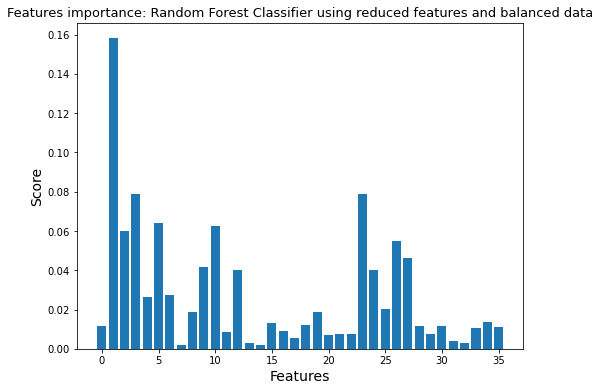

In [98]:
importance = rfc2.feature_importances_

# Resumen de la importancia de las variables de entrenamiento:
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title('Features importance: Random Forest Classifier using reduced features and balanced data', fontsize=13)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Features", fontsize=14)
plt.show()

**Validación:**

In [99]:
# Predicciones usando el modelo entrenado:
rfc2_predictions = rfc2.predict(reduced_test_df.values)

In [100]:
pred_f1_score = metrics.f1_score(test_labels_df.values, rfc2_predictions)
pred_gini_score = gini_normalized(test_labels_df.values, rfc2_predictions)

print('Random Forest Classifier (using reduced data) for validation stage:')
print(f'f1-score = {pred_f1_score}')
print(f'Gini score = {pred_gini_score}')

Random Forest Classifier (using reduced data) for validation stage:
f1-score = 0.8230088495575221
Gini score = 0.8042929292929295


**Análisis por matríz de confusión:**

In [101]:
print('Confusion matrix:')
metrics.confusion_matrix(test_labels_df.values, rfc2_predictions)

Confusion matrix:


array([[415,  25],
       [ 15,  93]])

In [102]:
clf_report = metrics.classification_report(test_labels_df.values, rfc2_predictions)
print('Classification report : \n', clf_report)

Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       440
         1.0       0.79      0.86      0.82       108

    accuracy                           0.93       548
   macro avg       0.88      0.90      0.89       548
weighted avg       0.93      0.93      0.93       548



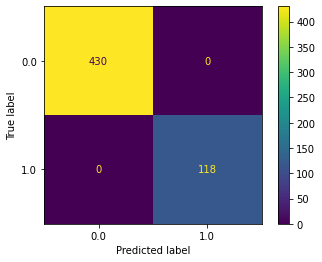

In [103]:
metrics.plot_confusion_matrix(rfc2, reduced_test_df.values, rfc2_predictions)
plt.show()

### Procedimiento propio diseñado para balanceo del conjunto de entrenamiento:
Sobre-muestreo de la clase minoritaria en el conjunto de entrenamiento con el fin de balancear los datos. Posteriormente, clasificación usando áboles de decisión aleatorios (Random Forest Classifier).

In [104]:
# Paso 1: División de las clases
big_class_df = train_df[train_labels_df['train_labels'] == 0] # class = 0
minor_class_df = train_df[train_labels_df['train_labels'] == 1] # class = 1

print(f'Big class amount: 0 --> {big_class_df.shape[0]}')
print(f'Minor class amount: 1 --> {minor_class_df.shape[0]}')

# Paso 2: Sobre-muestreo de la clase minoritaria:
minor_class_upsampled_df = resample(minor_class_df, replace=True, n_samples=1760, random_state=6)

# Paso 3: Combinando los datos sobre-muestreados con la clase majoritaria inicial:
new_train_df = pd.concat([big_class_df, minor_class_upsampled_df])
new_train_df = new_train_df.reset_index(drop=True)
print(f'Dimension of the new trainning data set = {new_train_df.shape}')

# Paso 4: Construir nuevo arreglo de etiquetas para entrenamiento
cl_0 = np.zeros(1760).transpose()
cl_1 = np.ones(1760).transpose()
new_train_labels = np.concatenate((cl_0, cl_1), axis=0)

print(f'Dimension of the new training labels array = {new_train_labels.shape}')

Big class amount: 0 --> 1760
Minor class amount: 1 --> 429
Dimension of the new trainning data set = (3520, 72)
Dimension of the new training labels array = (3520,)
